In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verificar se os datasets estão lá
import os
from pathlib import Path

base = Path('/content/drive/MyDrive/meus_modelos_ia/datasets')
bid_path = base / 'BID Dataset'
spotbid_path = base / 'SpotBID Set Dataset'

print("Verificando datasets...")
print(f"BID Dataset: {'✓ Encontrado' if bid_path.exists() else '✗ Não encontrado'}")
print(f"SpotBID Set: {'✓ Encontrado' if spotbid_path.exists() else '✗ Não encontrado'}")

if bid_path.exists():
    classes = [d.name for d in bid_path.iterdir() if d.is_dir()]
    print(f"\nClasses do BID: {len(classes)}")
    for cls in sorted(classes):
        num_imgs = len(list((bid_path / cls).glob('*.jpg')))
        print(f"  - {cls}: {num_imgs} imagens")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Verificando datasets...
BID Dataset: ✓ Encontrado
SpotBID Set: ✓ Encontrado

Classes do BID: 8
  - CNH_Aberta: 7200 imagens
  - CNH_Frente: 7200 imagens
  - CNH_Verso: 7200 imagens
  - CPF_Frente: 7200 imagens
  - CPF_Verso: 7200 imagens
  - RG_Aberto: 7200 imagens
  - RG_Frente: 7200 imagens
  - RG_Verso: 7200 imagens


In [ ]:

!pip install -q ultralytics transformers albumentations

print("✓ Instalação concluída!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.0 MB/s eta 0:00:00
✓ Instalação concluída!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ANÁLISE EXPLORATÓRIA - BID DATASET
Executando em: Google Colab
Base Path: /content/drive/MyDrive/meus_modelos_ia/datasets

### VERIFICANDO ESTRUTURA DOS DATASETS ###

✓ BID Dataset encontrado em: /content/drive/MyDrive/meus_modelos_ia/datasets/BID Dataset
  Classes encontradas: 8
    - CNH_Aberta
    - CNH_Frente
    - CNH_Verso
    - CPF_Frente
    - CPF_Verso
    - RG_Aberto
    - RG_Frente
    - RG_Verso

✓ SpotBID Set encontrado em: /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset
  Subpastas: ['validation_folder', 'train_folder']


### ANÁLISE DETALHADA - BID DATASET ###

RESUMO GERAL:
  Total de documentos únicos: 28800
  Documentos com anotações OCR: 28800
  Documentos com máscaras de segmentação: 28799

DISTRIBUIÇÃO POR CLASSE:
            num_documents  num_ocr  num_masks
Classe                                       
CNH_Aberta    

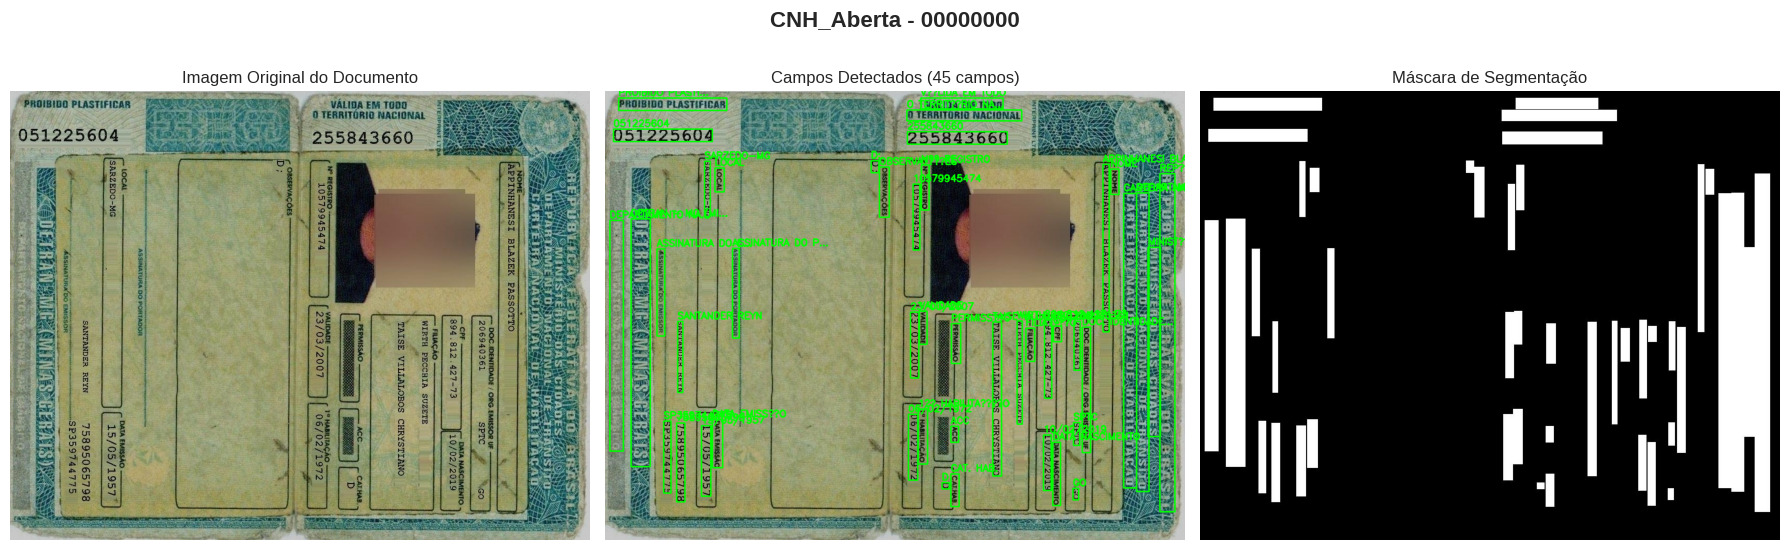


--- 📄 CNH_Frente ---

📝 Anotações de 00003604:
  1. REPÚBLICA FEDERATIVA DO BRASIL
  2. MINISTÉRIO DAS CIDADES
  3. DEPARTAMENTO NACIONAL DE TRÂNSITO
  4. CARTEIRA NACIONAL DE HABILITAÇÃO
  5. NOME
  ... e mais 25 campos


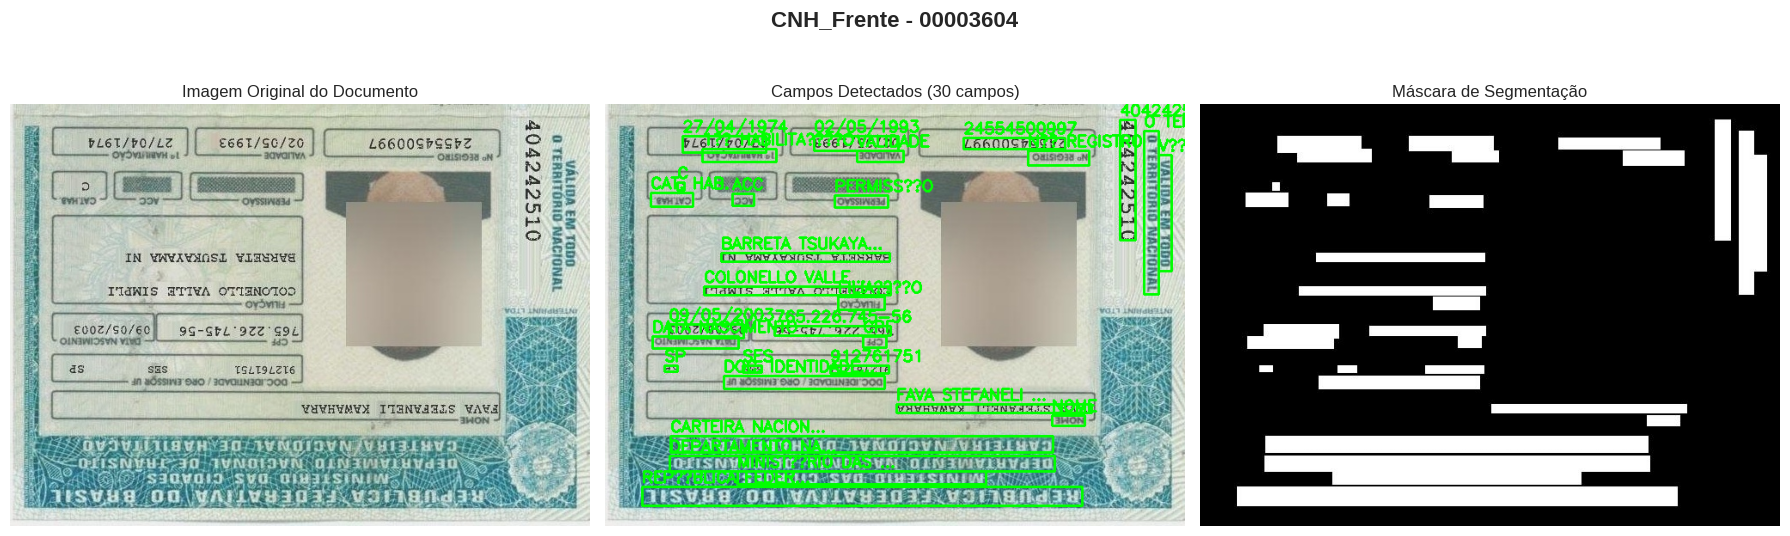


--- 📄 CNH_Verso ---

📝 Anotações de 00007256:
  1. OBSERVAÇÕES
  2. ASSINATURA DO PORTADOR
  3. LOCAL
  4. MAJOR VIEIRA-SC
  5. CECON LORENZI
  ... e mais 9 campos


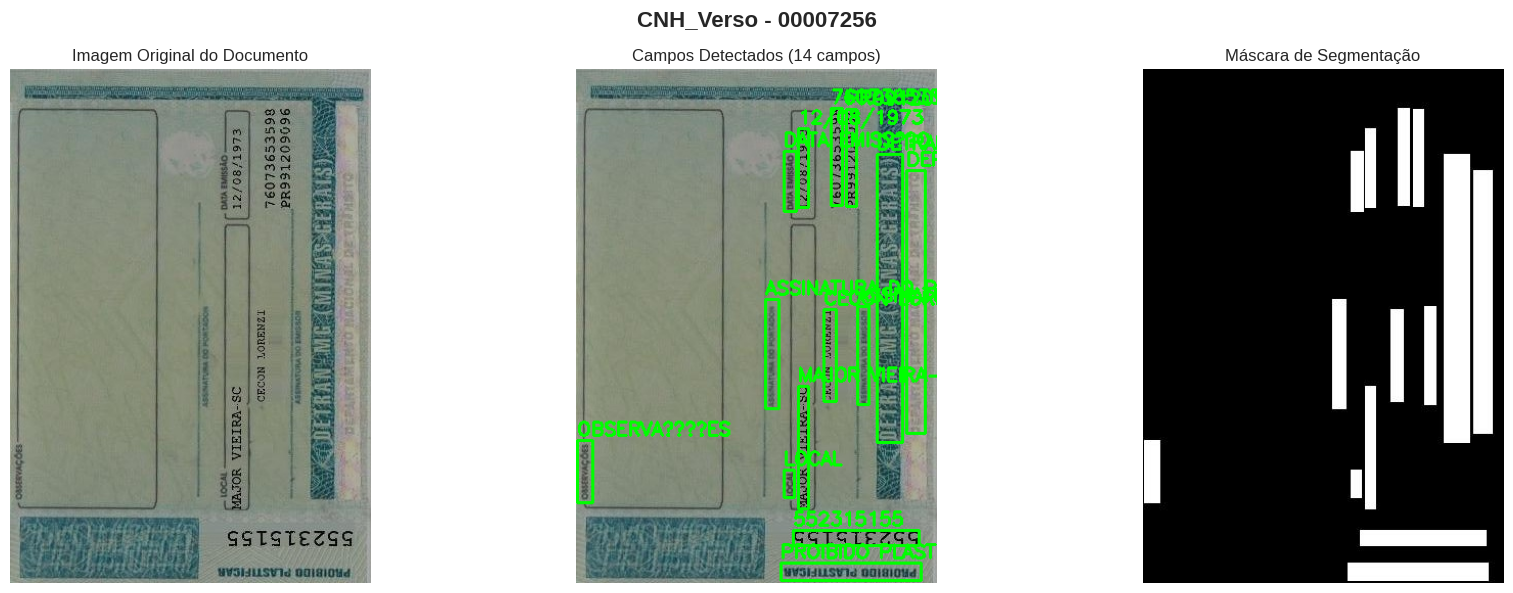


--- 📄 CPF_Frente ---

📝 Anotações de 00010892:
  1. MINISTÉRIO DA FAZENDA
  2. SECRETARIA DA RECEITA FEDERAL
  3. CPF
  4. CADASTRO DE PESSOAS FÍSICAS
  5. NÚMERO DE INSCRIÇÃO
  ... e mais 5 campos


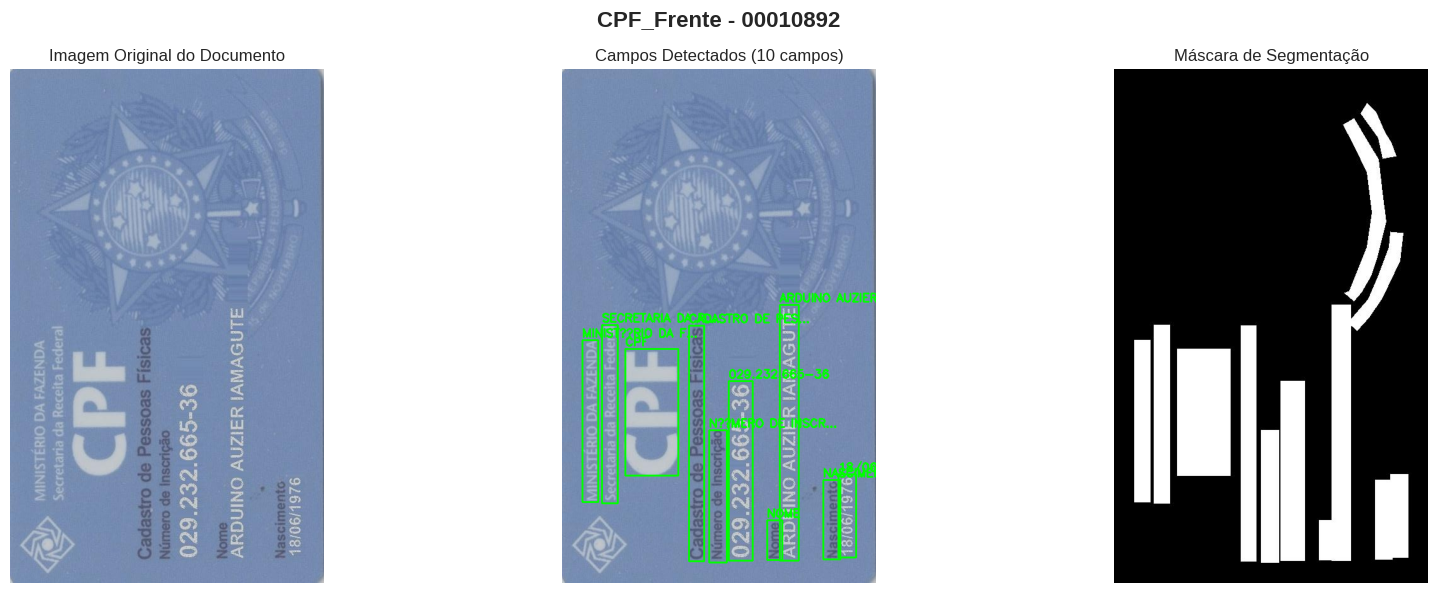


### ANÁLISE DAS ANOTAÇÕES OCR ###



In [ ]:
# ============================================================================
# PARTE 1: CONFIGURAÇÃO E IMPORTS
# ============================================================================

# Se estiver no Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    BASE_PATH = '/content/drive/MyDrive/meus_modelos_ia/datasets'
except:
    IN_COLAB = False
    BASE_PATH = '.'  

import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from PIL import Image
import json

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("ANÁLISE EXPLORATÓRIA - BID DATASET")
print("="*60)
print(f"Executando em: {'Google Colab' if IN_COLAB else 'Ambiente Local'}")
print(f"Base Path: {BASE_PATH}")
print("="*60)

# ============================================================================
# PARTE 2: VERIFICAÇÃO DA ESTRUTURA
# ============================================================================

print("\n### VERIFICANDO ESTRUTURA DOS DATASETS ###\n")

# Caminhos
BID_PATH = Path(BASE_PATH) / "BID Dataset"
SPOTBID_PATH = Path(BASE_PATH) / "SpotBID Set Dataset"

# Verificar BID Dataset
if BID_PATH.exists():
    print(f"✓ BID Dataset encontrado em: {BID_PATH}")

    # Listar classes
    classes_bid = [d.name for d in BID_PATH.iterdir() if d.is_dir() and not d.name.startswith('.')]
    print(f"  Classes encontradas: {len(classes_bid)}")
    for cls in sorted(classes_bid):
        print(f"    - {cls}")
else:
    print(f"✗ BID Dataset NÃO encontrado em: {BID_PATH}")
    print("  Ajuste o caminho BASE_PATH")

print()

# Verificar SpotBID Dataset
if SPOTBID_PATH.exists():
    print(f"✓ SpotBID Set encontrado em: {SPOTBID_PATH}")

    subfolders = [d.name for d in SPOTBID_PATH.iterdir() if d.is_dir()]
    print(f"  Subpastas: {subfolders}")
else:
    print(f"✗ SpotBID Set NÃO encontrado em: {SPOTBID_PATH}")

print("\n" + "="*60 + "\n")

# ============================================================================
# PARTE 3: ANÁLISE DO BID DATASET
# ============================================================================

print("### ANÁLISE DETALHADA - BID DATASET ###\n")

# Estrutura para guardar informações
bid_stats = {
    'classes': {},
    'total_documents': 0,
    'total_with_ocr': 0,
    'total_with_mask': 0,
    'image_sizes': [],
    'file_sizes_mb': []
}

# Analisar cada classe
for class_name in sorted(classes_bid):
    class_path = BID_PATH / class_name

    # Usando padrão correto dos arquivos
    document_images = list(class_path.glob("*_in.jpg"))
    ocr_files = list(class_path.glob("*_gt_ocr.txt"))
    mask_files = list(class_path.glob("*_gt_segmentation.jpg"))

    bid_stats['classes'][class_name] = {
        'num_documents': len(document_images),
        'num_ocr': len(ocr_files),
        'num_masks': len(mask_files)
    }

    bid_stats['total_documents'] += len(document_images)
    bid_stats['total_with_ocr'] += len(ocr_files)
    bid_stats['total_with_mask'] += len(mask_files)

    # Analisar tamanhos das imagens (amostra de 10)
    for img_path in document_images[:10]:
        try:
            img = Image.open(img_path)
            bid_stats['image_sizes'].append(img.size)

            # Tamanho do arquivo
            file_size_mb = img_path.stat().st_size / (1024 * 1024)
            bid_stats['file_sizes_mb'].append(file_size_mb)
        except Exception as e:
            print(f"Erro ao ler {img_path}: {e}")
            pass

# Exibir resultados
print("RESUMO GERAL:")
print(f"  Total de documentos únicos: {bid_stats['total_documents']}")
print(f"  Documentos com anotações OCR: {bid_stats['total_with_ocr']}")
print(f"  Documentos com máscaras de segmentação: {bid_stats['total_with_mask']}")
print()

print("DISTRIBUIÇÃO POR CLASSE:")
df_classes = pd.DataFrame(bid_stats['classes']).T
df_classes.index.name = 'Classe'
print(df_classes.to_string())
print()

# Estatísticas de tamanho
if bid_stats['image_sizes']:
    widths = [size[0] for size in bid_stats['image_sizes']]
    heights = [size[1] for size in bid_stats['image_sizes']]

    print("DIMENSÕES DAS IMAGENS:")
    print(f"  Largura média: {np.mean(widths):.0f} px")
    print(f"  Altura média: {np.mean(heights):.0f} px")
    print(f"  Tamanho arquivo médio: {np.mean(bid_stats['file_sizes_mb']):.2f} MB")
    print()

# ============================================================================
# PARTE 4: VISUALIZAÇÃO DE AMOSTRAS
# ============================================================================

print("### VISUALIZANDO AMOSTRAS ###\n")

def visualize_bid_sample(class_name, index=0):
    """Visualiza amostra completa de um documento, seguindo o padrão oficial do BID Dataset"""
    class_path = BID_PATH / class_name

    # Pega apenas as imagens originais dos documentos
    document_images = sorted(list(class_path.glob("*_in.jpg")))

    if not document_images:
        print(f"Nenhuma imagem de documento encontrada para a classe {class_name}")
        return

    # Se o índice for maior que o número de arquivos, usa o primeiro
    if index >= len(document_images):
        index = 0

    img_path = document_images[index]
    # Extrai o código base do arquivo (ex: de 0000192_in.jpg pega 0000192)
    base_name = img_path.stem.replace("_in", "")

    # Caminhos corretos para anotação e máscara
    ocr_path = class_path / f"{base_name}_gt_ocr.txt"
    mask_path = class_path / f"{base_name}_gt_segmentation.jpg"

    # Carregar imagem original
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{class_name} - {base_name}', fontsize=16, fontweight='bold')

    # 1. Imagem original
    axes[0].imshow(img)
    axes[0].set_title('Imagem Original do Documento')
    axes[0].axis('off')

    # 2. Imagem com bounding boxes
    if ocr_path.exists():
        img_with_boxes = img.copy()
        annotations = []

       # Lê o arquivo com codificação latin-1 para evitar erro de caracteres
        with open(ocr_path, 'r', encoding='latin-1') as f:
            lines = f.readlines()

        # O BID Dataset tem sempre 1 linha de cabeçalho, pula ela
        for line in lines[1:]:
            parts = line.strip().split(',', 4)
            if len(parts) >= 5:
                try:
                    x, y, w, h = map(int, parts[:4])
                    text = parts[4].strip()
                    annotations.append((x, y, w, h, text))

                    # Desenhar bounding box e rótulo
                    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    label = text[:15] + '...' if len(text) > 15 else text
                    cv2.putText(img_with_boxes, label, (x, y-5),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                except Exception as e:
                    continue

        axes[1].imshow(img_with_boxes)
        axes[1].set_title(f'Campos Detectados ({len(annotations)} campos)')
        axes[1].axis('off')

        # Mostra algumas anotações no terminal
        print(f"\n📝 Anotações de {base_name}:")
        for i, (x, y, w, h, text) in enumerate(annotations[:5], 1):
            print(f"  {i}. {text}")
        if len(annotations) > 5:
            print(f"  ... e mais {len(annotations)-5} campos")
    else:
        axes[1].text(0.5, 0.5, 'Arquivo de OCR não encontrado',
                    ha='center', va='center', fontsize=12)
        axes[1].axis('off')

    # 3. Máscara de segmentação
    if mask_path.exists():
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Máscara de Segmentação')
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, 'Máscara não encontrada',
                    ha='center', va='center', fontsize=12)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar 1 amostra das primeiras 4 classes
for class_name in sorted(classes_bid)[:4]:
    print(f"\n--- 📄 {class_name} ---")
    visualize_bid_sample(class_name, index=0)

# ============================================================================
# PARTE 5: ANÁLISE DE ANOTAÇÕES
# ============================================================================

print("\n### ANÁLISE DAS ANOTAÇÕES OCR ###\n")

# Coletar estatísticas de anotações
annotation_stats = {
    'total_annotations': 0,
    'annotations_per_image': [],
    'text_lengths': [],
    'field_types': Counter(),
    'transcriptions': []
}

for class_name in sorted(classes_bid):
    class_path = BID_PATH / class_name

    for ocr_file in class_path.glob("*_gt_ocr.txt"):
        # CORREÇÃO 1: Abre o arquivo com encoding latin-1
        try:
            with open(ocr_file, 'r', encoding='latin-1') as f:
                lines = f.readlines()[1:]  # Pular cabeçalho
        except:
            # Fallback caso ainda de erro
            with open(ocr_file, 'r', encoding='utf-8', errors='replace') as f:
                lines = f.readlines()[1:]

        num_annotations = 0
        for line in lines:
            parts = line.strip().split(',', 4)
            if len(parts) >= 5:
                try:
                    text = parts[4].strip()
                    annotation_stats['total_annotations'] += 1
                    annotation_stats['text_lengths'].append(len(text))
                    annotation_stats['transcriptions'].append(text)
                    num_annotations += 1

                    # Classificar tipo de campo
                    text_lower = text.lower()
                    if any(kw in text_lower for kw in ['nome', 'data', 'cpf', 'rg', 'nis', 'orgão']):
                        annotation_stats['field_types']['descrição'] += 1
                    elif text.replace(' ', '').replace('.', '').replace('-', '').isdigit():
                        annotation_stats['field_types']['numérico'] += 1
                    else:
                        annotation_stats['field_types']['texto'] += 1
                except:
                    continue

        if num_annotations > 0:
            annotation_stats['annotations_per_image'].append(num_annotations)

print("📊 ESTATÍSTICAS DAS ANOTAÇÕES:")
print(f"  Total de anotações: {annotation_stats['total_annotations']}")
print(f"  Média de anotações por documento: {np.mean(annotation_stats['annotations_per_image']):.1f}")
print(f"  Mínimo de anotações: {np.min(annotation_stats['annotations_per_image'])}")
print(f"  Máximo de anotações: {np.max(annotation_stats['annotations_per_image'])}")
print()

print("🏷️ TIPOS DE CAMPOS:")
for field_type, count in annotation_stats['field_types'].most_common():
    pct = (count / annotation_stats['total_annotations']) * 100
    print(f"  {field_type:12s}: {count:6d} ({pct:5.1f}%)")
print()

print("📏 COMPRIMENTO DOS TEXTOS:")
print(f"  Média: {np.mean(annotation_stats['text_lengths']):.1f} caracteres")
print(f"  Mediana: {np.median(annotation_stats['text_lengths']):.0f} caracteres")
print(f"  Máximo: {np.max(annotation_stats['text_lengths'])} caracteres")
print()

# Textos mais comuns
print("🔤 TEXTOS MAIS COMUNS (TOP 10):")
text_counter = Counter(annotation_stats['transcriptions'])
for text, count in text_counter.most_common(10):
    display_text = text[:30] + '...' if len(text) > 30 else text
    print(f"  '{display_text}' -> {count}x")

# ============================================================================
# PARTE 6: VISUALIZAÇÕES ESTATÍSTICAS
# ============================================================================

print("\n### GERANDO GRÁFICOS ###\n")

# Gráfico 1: Distribuição de imagens por classe
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Barplot de classes
classes_counts = [bid_stats['classes'][cls]['num_documents'] for cls in sorted(classes_bid)]
axes[0, 0].bar(range(len(classes_bid)), classes_counts, color='skyblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(classes_bid)))
axes[0, 0].set_xticklabels(sorted(classes_bid), rotation=45, ha='right')
axes[0, 0].set_ylabel('Número de Documentos')
axes[0, 0].set_title('Distribuição de Documentos por Classe')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Histograma de anotações por imagem
axes[0, 1].hist(annotation_stats['annotations_per_image'], bins=20,
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(annotation_stats['annotations_per_image']),
                  color='red', linestyle='--', label=f'Média: {np.mean(annotation_stats["annotations_per_image"]):.1f}')
axes[0, 1].set_xlabel('Número de Anotações')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Anotações por Documento')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Pie chart de tipos de campos
field_labels = list(annotation_stats['field_types'].keys())
field_values = list(annotation_stats['field_types'].values())
axes[1, 0].pie(field_values, labels=field_labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Distribuição de Tipos de Campos')

# 4. Histograma de comprimento de textos
axes[1, 1].hist(annotation_stats['text_lengths'], bins=30,
               color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(np.mean(annotation_stats['text_lengths']),
                  color='red', linestyle='--', label=f'Média: {np.mean(annotation_stats["text_lengths"]):.1f}')
axes[1, 1].set_xlabel('Comprimento do Texto (caracteres)')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title('Distribuição do Comprimento dos Textos')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('bid_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo em: bid_statistics.png")

# ============================================================================
# PARTE 7: ANÁLISE DO SPOTBID DATASET
# ============================================================================

if SPOTBID_PATH.exists():
    print("\n### ANÁLISE - SPOTBID SET DATASET ###\n")

    spotbid_stats = {}

    # Usar as pastas que aparecem no dataset
    for folder in ['train_folder', 'validation_folder']:
        folder_path = SPOTBID_PATH / folder

        if folder_path.exists():
            images = list(folder_path.glob("*.jpg")) + list(folder_path.glob("*.png"))
            spotbid_stats[folder] = len(images)
            print(f"  📂 {folder}: {len(images)} imagens")
        else:
            spotbid_stats[folder] = 0
            print(f"  ❌ {folder}: pasta não encontrada")

    total_spotbid = sum(spotbid_stats.values())
    print(f"\n  📸 Total de imagens no SpotBID: {total_spotbid}")

    if total_spotbid > 0:
        # Visualizar amostras
        print("\n  🖼️ Visualizando amostras do SpotBID...")

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('SpotBID Set - Amostras', fontsize=16, fontweight='bold')

        for i, folder in enumerate(['train_folder', 'validation_folder']):
            folder_path = SPOTBID_PATH / folder
            images = list(folder_path.glob("*.jpg"))[:3]

            for j, img_path in enumerate(images):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{folder} - {j+1}')
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.savefig('spotbid_samples.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("  ✓ Amostras salvas em: spotbid_samples.png")

# ============================================================================
# PARTE 8: RESUMO FINAL
# ============================================================================

print("\n" + "="*60)
print("RESUMO DA ANÁLISE EXPLORATÓRIA")
print("="*60)

print("\n📊 BID DATASET:")
print(f"  - Total de documentos únicos: {bid_stats['total_documents']}")
print(f"  - Classes: {len(classes_bid)}")
print(f"  - Documentos com anotações OCR: {bid_stats['total_with_ocr']}")
print(f"  - Total de anotações: {annotation_stats['total_annotations']}")
print(f"  - Média de anotações por documento: {np.mean(annotation_stats['annotations_per_image']):.1f}")

if SPOTBID_PATH.exists() and total_spotbid > 0:
    print("\n📸 SPOTBID SET:")
    print(f"  - Total de imagens: {total_spotbid}")
    print(f"  - Dados de treino: {spotbid_stats.get('train_folder', 0)}")
    print(f"  - Dados de validação: {spotbid_stats.get('validation_folder', 0)}")

print("\n✅ PRÓXIMOS PASSOS:")
print("  1. Converter BID Dataset para formato YOLO para detecção de campos")
print("  2. Treinar modelo de detecção de spotlight no SpotBID")
print("  3. Treinar classificador de documentos")
print("  4. Fine-tuning de modelo OCR como o EasyOCR ou PaddleOCR")
print("  5. Integrar um pipeline completo de processamento de documentos")

print("\n" + "="*60)
print("ANÁLISE CONCLUÍDA!")
print("="*60)

In [ ]:
"""
QUICK START - CONFIGURAÇÃO INICIAL DO PROJETO
==============================================
"""

import os
import sys
import shutil
from pathlib import Path

# ============================================================================
# CONFIGURAÇÃO
# ============================================================================

print("="*70)
print("🚀 QUICK START - CLASSIFICAÇÃO DE DOCUMENTOS BRASILEIROS")
print("="*70)

# Detectar ambiente
try:
    from google.colab import drive
    IN_COLAB = True
    print("\n✓ Ambiente: Google Colab")

    # Montar Drive apenas se não estiver montado
    if not os.path.exists('/content/drive'):
        print("  Montando Google Drive...")
        drive.mount('/content/drive')

    BASE_PATH = Path('/content/drive/MyDrive/meus_modelos_ia/datasets')

except ImportError:
    IN_COLAB = False
    print("\n✓ Ambiente: Local")
    base_input = input("\nDigite o caminho base dos datasets (ou Enter para usar atual): ").strip()
    BASE_PATH = Path(base_input) if base_input else Path.cwd()

print(f"  Base Path: {BASE_PATH}")

# ============================================================================
# VERIFICAÇÃO DOS DATASETS
# ============================================================================

print("\n" + "="*70)
print("📂 VERIFICANDO DATASETS")
print("="*70)

# Caminhos
BID_PATH = BASE_PATH / "BID Dataset"
SPOTBID_PATH = BASE_PATH / "SpotBID Set Dataset"

# Classes esperadas
EXPECTED_BID_CLASSES = [
    'CNH_Frente', 'CNH_Verso', 'CNH_Aberta',
    'RG_Frente', 'RG_Verso', 'RG_Aberto',
    'CPF_Frente', 'CPF_Verso'
]

# 1. Verificar BID Dataset
print("\n1️⃣ BID Dataset:")
bid_ok = False

if BID_PATH.exists():
    print(f"   ✓ Pasta encontrada: {BID_PATH}")

    found_classes = [d.name for d in BID_PATH.iterdir() if d.is_dir() and not d.name.startswith('.')]

    # Validação de classes
    missing = set(EXPECTED_BID_CLASSES) - set(found_classes)
    if not missing:
        print(f"   ✓ Todas as {len(EXPECTED_BID_CLASSES)} classes encontradas")
        bid_ok = True
    else:
        print(f"   ⚠ Classes faltando: {missing}")

    # Contagem correta de arquivos
    total_docs = 0
    total_ocr = 0
    total_masks = 0

    for cls in found_classes:
        cls_path = BID_PATH / cls
        docs = list(cls_path.glob("*_in.jpg"))
        ocr = list(cls_path.glob("*_gt_ocr.txt"))
        masks = list(cls_path.glob("*_gt_segmentation.jpg"))

        total_docs += len(docs)
        total_ocr += len(ocr)
        total_masks += len(masks)

    print(f"\n   📊 Estatísticas Reais:")
    print(f"      - Documentos (*_in.jpg): {total_docs}")
    print(f"      - OCR/Labels (*_gt_ocr.txt): {total_ocr}")
    print(f"      - Máscaras (*_gt_segmentation.jpg): {total_masks}")

    if total_docs == 0:
        print(f"   ❌ ERRO: Nenhuma imagem encontrada com o padrão *_in.jpg!")
        bid_ok = False
else:
    print(f"   ❌ PASTA NÃO ENCONTRADA: {BID_PATH}")
    bid_ok = False

# 2. Verificar SpotBID Dataset
print("\n2️⃣ SpotBID Set Dataset:")
spotbid_ok = False

if SPOTBID_PATH.exists():
    print(f"   ✓ Pasta encontrada: {SPOTBID_PATH}")

    train_dir = SPOTBID_PATH / 'train_folder'
    val_dir = SPOTBID_PATH / 'validation_folder'

    alt_c1 = SPOTBID_PATH / 'com_oclusao'
    alt_c2 = SPOTBID_PATH / 'sem_oclusao'

    if train_dir.exists() and val_dir.exists():
        print(f"   ✓ Estrutura encontrada: train_folder / validation_folder")
        n_train = len(list(train_dir.rglob("*.jpg"))) + len(list(train_dir.rglob("*.png")))
        n_val = len(list(val_dir.rglob("*.jpg"))) + len(list(val_dir.rglob("*.png")))
        print(f"      - Treino: {n_train} imagens")
        print(f"      - Validação: {n_val} imagens")
        spotbid_ok = True

    elif alt_c1.exists() and alt_c2.exists():
        print(f"   ✓ Estrutura encontrada: com_oclusao / sem_oclusao")
        spotbid_ok = True
    else:
        print(f"   ❌ Estrutura desconhecida dentro do SpotBID.")
        print(f"      Pastas encontradas: {[d.name for d in SPOTBID_PATH.iterdir() if d.is_dir()]}")
else:
    print(f"   ❌ PASTA NÃO ENCONTRADA: {SPOTBID_PATH}")

# ============================================================================
# INSTALAÇÃO DE DEPENDÊNCIAS
# ============================================================================

print("\n" + "="*70)
print("📦 VERIFICANDO DEPENDÊNCIAS")
print("="*70)

required_packages = {
    'torch': 'torch',
    'cv2': 'opencv-python',
    'PIL': 'Pillow',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'ultralytics': 'ultralytics', # Essencial para YOLOv8
    'sklearn': 'scikit-learn'
}

missing_packages = []
for import_name, package_name in required_packages.items():
    try:
        __import__(import_name)
        print(f"   ✓ {package_name}")
    except ImportError:
        missing_packages.append(package_name)

if missing_packages:
    print(f"\n   ⚠ Pacotes faltando: {missing_packages}")
    if IN_COLAB:
        print("   Instalando automaticamente...")
        for pkg in missing_packages:
            os.system(f"pip install -q {pkg}")
        print("   ✓ Instalação concluída!")
    else:
        print(f"   Execute: pip install {' '.join(missing_packages)}")

# ============================================================================
# ESTRUTURA DO PROJETO E CONFIG
# ============================================================================

print("\n" + "="*70)
print("📁 CONFIGURANDO PROJETO")
print("="*70)

PROJECT_ROOT = BASE_PATH / "document-classifier"
dirs = [
    PROJECT_ROOT / "models/yolo_classifier",
    PROJECT_ROOT / "models/spotlight_detector",
    PROJECT_ROOT / "data/yolo_dataset/train",
    PROJECT_ROOT / "data/yolo_dataset/val",
    PROJECT_ROOT / "results",
]

for d in dirs:
    d.mkdir(parents=True, exist_ok=True)


config_content = f"""
# ARQUIVO DE CONFIGURAÇÃO AUTOMÁTICO
from pathlib import Path

BASE_PATH = Path(r"{BASE_PATH}")
PROJECT_ROOT = BASE_PATH / "document-classifier"

# Datasets Originais
BID_PATH = BASE_PATH / "BID Dataset"
SPOTBID_PATH = BASE_PATH / "SpotBID Set Dataset"

# Onde salvar dados processados para YOLO
YOLO_DATASET_DIR = PROJECT_ROOT / "data/yolo_dataset"

# Parâmetros
IMG_SIZE = 640
BATCH_SIZE = 16
"""

with open(PROJECT_ROOT / "config.py", "w", encoding="utf-8") as f:
    f.write(config_content)

print(f"   ✓ Estrutura criada em: {PROJECT_ROOT}")
print(f"   ✓ Configuração salva em: {PROJECT_ROOT}/config.py")

print("\n" + "="*70)
print(f"🎉 CHECK-UP CONCLUÍDO!")
print(f"Status BID: {'✅ OK' if bid_ok else '❌ ERRO'}")
print(f"Status SpotBID: {'✅ OK' if spotbid_ok else '❌ ERRO'}")
print("="*70)

🚀 QUICK START - CLASSIFICAÇÃO DE DOCUMENTOS BRASILEIROS

✓ Ambiente: Google Colab
  Base Path: /content/drive/MyDrive/meus_modelos_ia/datasets

📂 VERIFICANDO DATASETS

1️⃣ BID Dataset:
   ✓ Pasta encontrada: /content/drive/MyDrive/meus_modelos_ia/datasets/BID Dataset
   ✓ Todas as 8 classes encontradas

   📊 Estatísticas Reais:
      - Documentos (*_in.jpg): 28800
      - OCR/Labels (*_gt_ocr.txt): 28800
      - Máscaras (*_gt_segmentation.jpg): 28799

2️⃣ SpotBID Set Dataset:
   ✓ Pasta encontrada: /content/drive/MyDrive/meus_modelos_ia/datasets/SpotBID Set Dataset
   ✓ Estrutura encontrada: train_folder / validation_folder
      - Treino: 31300 imagens
      - Validação: 10432 imagens

📦 VERIFICANDO DEPENDÊNCIAS
   ✓ torch
   ✓ opencv-python
   ✓ Pillow
   ✓ pandas
   ✓ matplotlib
   ✓ ultralytics
   ✓ scikit-learn

📁 CONFIGURANDO PROJETO
   ✓ Estrutura criada em: /content/drive/MyDrive/meus_modelos_ia/datasets/document-classifier
   ✓ Configuração salva em: /content/drive/MyDrive/me

In [ ]:
output_dir = '/content/drive/MyDrive/meus_modelos_ia/datasets/document-classifier-yolo/data/yolo_format'

In [ ]:
from bid_parser import BIDDatasetParser


bid_root = "/content/drive/MyDrive/meus_modelos_ia/datasets/BID Dataset"
output_yolo = "/content/drive/MyDrive/document-classifier/data/yolo_format"

# Inicializar parser com correção
parser = BIDDatasetParser(bid_root)

# Ver estatísticas (opcional)
parser.print_statistics()

# Exportar para YOLO format
parser.export_to_yolo(
    output_dir=output_yolo,
    split={'train': 0.7, 'val': 0.2, 'test': 0.1}
)

In [ ]:
import os
import shutil
import random
import yaml
import zipfile
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image

# ============================================================================
# CONVERSOR BID DATASET → YOLO
# Objetivo: Classificar tipo de documento (CNH_Frente, RG_Verso, etc.)
# ============================================================================

class BIDToYOLO:
    """
    Converte BID Dataset para formato YOLO.

    Estrutura do BID:
    - 00004660_in.jpg              → Imagem do documento
    - 00004660_gt_ocr.txt          → Anotações OCR
    - 00004660_gt_segmentation.jpg → Máscara de segmentação

    Objetivo:
    - Classificar o tipo de documento (não detectar campos individuais)
    - Cada imagem = 1 bounding box cobrindo o documento inteiro
    """

    def __init__(self, root_path):
        self.root_path = Path(root_path)

        if not self.root_path.exists():
            raise FileNotFoundError(f"❌ Dataset não encontrado: {self.root_path}")

        # Listar classes (pastas)
        self.classes = sorted([
            d.name for d in self.root_path.iterdir()
            if d.is_dir() and not d.name.startswith('.')
        ])

        if not self.classes:
            raise ValueError(f"❌ Nenhuma classe encontrada em {self.root_path}")

        # Mapear classe → ID
        self.class_to_id = {cls: idx for idx, cls in enumerate(self.classes)}

        print(f"✅ Classes encontradas: {len(self.classes)}")
        for cls, idx in self.class_to_id.items():
            print(f"   [{idx}] {cls}")

        # Carregar dados
        self.data = []
        self._scan_dataset()

    def _scan_dataset(self):
        """Escaneia o dataset e lista todas as imagens."""
        print(f"\n🔍 Escaneando dataset...")

        for cls in tqdm(self.classes, desc="Classes"):
            cls_path = self.root_path / cls

            # Procurar apenas imagens _in.jpg
            images = list(cls_path.glob("*_in.jpg"))

            for img_path in images:
                # Extrair base name (sem _in.jpg)
                base_name = img_path.stem.replace("_in", "")

                # Verificar se existem os arquivos relacionados
                txt_path = cls_path / f"{base_name}_gt_ocr.txt"
                mask_path = cls_path / f"{base_name}_gt_segmentation.jpg"

                self.data.append({
                    'image_path': img_path,
                    'txt_path': txt_path if txt_path.exists() else None,
                    'mask_path': mask_path if mask_path.exists() else None,
                    'class_name': cls,
                    'class_id': self.class_to_id[cls],
                    'base_name': base_name
                })

        print(f"✅ Total de documentos: {len(self.data)}")

        # Estatísticas
        print(f"\n📊 Distribuição por classe:")
        for cls in self.classes:
            count = sum(1 for d in self.data if d['class_name'] == cls)
            pct = (count / len(self.data)) * 100
            print(f"   {cls:20s}: {count:5d} ({pct:5.1f}%)")

    def export_to_yolo(self, output_dir, split={'train': 0.7, 'val': 0.2, 'test': 0.1}):
        """
        Exporta dataset para formato YOLO e zipa.

        Args:
            output_dir: Pasta de destino (Google Drive)
            split: Divisão treino/validação/teste
        """

        # Diretório temporário local (rápido)
        temp_dir = Path('/content/temp_yolo_bid')
        if temp_dir.exists():
            shutil.rmtree(temp_dir)

        print(f"\n🚀 Gerando dataset YOLO...")

        # Criar estrutura de pastas
        for subset in ['train', 'val', 'test']:
            (temp_dir / 'images' / subset).mkdir(parents=True, exist_ok=True)
            (temp_dir / 'labels' / subset).mkdir(parents=True, exist_ok=True)

        # Dividir dataset
        print(f"\n📂 Dividindo dataset...")
        random.seed(42)  # Reprodutibilidade
        random.shuffle(self.data)

        n_total = len(self.data)
        n_train = int(n_total * split['train'])
        n_val = int(n_total * split['val'])

        splits = {
            'train': self.data[:n_train],
            'val': self.data[n_train:n_train + n_val],
            'test': self.data[n_train + n_val:]
        }

        print(f"   Train: {len(splits['train'])} imagens")
        print(f"   Val:   {len(splits['val'])} imagens")
        print(f"   Test:  {len(splits['test'])} imagens")

        # Processar cada subset
        for subset_name, items in splits.items():
            print(f"\n📦 Processando {subset_name}...")

            for item in tqdm(items, desc=f"  {subset_name}"):
                try:
                    # Nome único da imagem (evita colisões)
                    filename = f"{item['class_name']}_{item['base_name']}"

                    # 1. Copiar imagem
                    img_dest = temp_dir / 'images' / subset_name / f"{filename}.jpg"
                    shutil.copy(item['image_path'], img_dest)

                    # 2. Criar label YOLO
                    # Para classificação de documento:
                    # - 1 bounding box cobrindo toda a imagem
                    # - Centro = (0.5, 0.5)
                    # - Tamanho = (1.0, 1.0) ou (0.95, 0.95) para deixar margem

                    class_id = item['class_id']

                    # Formato YOLO: class_id x_center y_center width height
                    yolo_label = f"{class_id} 0.5 0.5 1.0 1.0"

                    # 3. Salvar label
                    label_dest = temp_dir / 'labels' / subset_name / f"{filename}.txt"
                    with open(label_dest, 'w') as f:
                        f.write(yolo_label)

                except Exception as e:
                    print(f"\n⚠️  Erro ao processar {item['image_path'].name}: {e}")
                    continue

        # Criar data.yaml
        print(f"\n📝 Criando data.yaml...")

        yaml_content = {
            'path': '/content/bid_yolo',  # Caminho quando descompactar
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': len(self.classes),
            'names': self.classes
        }

        yaml_path = temp_dir / 'data.yaml'
        with open(yaml_path, 'w') as f:
            yaml.dump(yaml_content, f, sort_keys=False)

        print("\n📄 Conteúdo do data.yaml:")
        print(yaml.dump(yaml_content, sort_keys=False))

        # Zipar tudo
        print(f"\n📦 Compactando dataset...")
        zip_path = Path('/content/bid_yolo_dataset.zip')

        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED, compresslevel=6) as zf:
            for root, _, files in os.walk(temp_dir):
                for file in tqdm(files, desc="  Zipando", leave=False):
                    file_path = Path(root) / file
                    arcname = file_path.relative_to(temp_dir)
                    zf.write(file_path, arcname)

        print(f"   ✅ ZIP criado: {zip_path}")
        print(f"   📦 Tamanho: {zip_path.stat().st_size / (1024**2):.2f} MB")

        # Copiar para Google Drive
        print(f"\n💾 Copiando para Google Drive...")

        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        final_path = output_path / 'bid_yolo_dataset.zip'
        shutil.copy(zip_path, final_path)

        # Limpar temporários
        print(f"\n🧹 Limpando arquivos temporários...")
        shutil.rmtree(temp_dir)
        zip_path.unlink()

        # Resumo final
        print(f"\n{'='*70}")
        print(f"✅ DATASET YOLO CRIADO COM SUCESSO!")
        print(f"{'='*70}")
        print(f"\n📍 Localização: {final_path}")
        print(f"📦 Tamanho: {final_path.stat().st_size / (1024**2):.2f} MB")
        print(f"\n🎯 Objetivo: Classificar tipo de documento")
        print(f"📊 Classes ({len(self.classes)}):")
        for i, cls in enumerate(self.classes):
            print(f"   [{i}] {cls}")

        print(f"\n🚀 PRÓXIMO PASSO:")
        print(f"   1. Descompactar no Colab:")
        print(f"      !unzip -q '{final_path}' -d /content/bid_yolo")
        print(f"\n   2. Treinar YOLO:")
        print(f"      from ultralytics import YOLO")
        print(f"      model = YOLO('yolov8n.pt')")
        print(f"      model.train(data='/content/bid_yolo/data.yaml', epochs=50)")

        return final_path

# ============================================================================
# EXECUÇÃO
# ============================================================================

if __name__ == "__main__":
    # Caminhos
    INPUT_DATASET = "/content/drive/MyDrive/meus_modelos_ia/datasets/BID Dataset"
    OUTPUT_FOLDER = "/content/drive/MyDrive/document-classifier/data"

    try:
        # Criar conversor
        print("="*70)
        print("BID DATASET → YOLO CONVERTER")
        print("="*70)

        converter = BIDToYOLO(INPUT_DATASET)

        # Exportar
        final_path = converter.export_to_yolo(OUTPUT_FOLDER)

        print(f"\n{'='*70}")
        print(f"🎉 PROCESSO CONCLUÍDO!")
        print(f"{'='*70}")

    except Exception as e:
        print(f"\n❌ ERRO: {e}")
        import traceback
        traceback.print_exc()

BID DATASET → YOLO CONVERTER
✅ Classes encontradas: 8
   [0] CNH_Aberta
   [1] CNH_Frente
   [2] CNH_Verso
   [3] CPF_Frente
   [4] CPF_Verso
   [5] RG_Aberto
   [6] RG_Frente
   [7] RG_Verso

🔍 Escaneando dataset...


Classes:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Total de documentos: 28800

📊 Distribuição por classe:
   CNH_Aberta          :  3600 ( 12.5%)
   CNH_Frente          :  3600 ( 12.5%)
   CNH_Verso           :  3600 ( 12.5%)
   CPF_Frente          :  3600 ( 12.5%)
   CPF_Verso           :  3600 ( 12.5%)
   RG_Aberto           :  3600 ( 12.5%)
   RG_Frente           :  3600 ( 12.5%)
   RG_Verso            :  3600 ( 12.5%)

🚀 Gerando dataset YOLO...

📂 Dividindo dataset...
   Train: 20160 imagens
   Val:   5760 imagens
   Test:  2880 imagens

📦 Processando train...


  train:   0%|          | 0/20160 [00:00<?, ?it/s]


📦 Processando val...


  val:   0%|          | 0/5760 [00:00<?, ?it/s]


📦 Processando test...


  test:   0%|          | 0/2880 [00:00<?, ?it/s]


📝 Criando data.yaml...

📄 Conteúdo do data.yaml:
path: /content/bid_yolo
train: images/train
val: images/val
test: images/test
nc: 8
names:
- CNH_Aberta
- CNH_Frente
- CNH_Verso
- CPF_Frente
- CPF_Verso
- RG_Aberto
- RG_Frente
- RG_Verso


📦 Compactando dataset...


  Zipando:   0%|          | 0/1 [00:00<?, ?it/s]

  Zipando: 0it [00:00, ?it/s]

  Zipando:   0%|          | 0/20160 [00:00<?, ?it/s]

  Zipando:   0%|          | 0/5760 [00:00<?, ?it/s]

  Zipando:   0%|          | 0/2880 [00:00<?, ?it/s]

  Zipando: 0it [00:00, ?it/s]

  Zipando:   0%|          | 0/20160 [00:00<?, ?it/s]

  Zipando:   0%|          | 0/5760 [00:00<?, ?it/s]

  Zipando:   0%|          | 0/2880 [00:00<?, ?it/s]

   ✅ ZIP criado: /content/bid_yolo_dataset.zip
   📦 Tamanho: 6773.33 MB

💾 Copiando para Google Drive...

🧹 Limpando arquivos temporários...

✅ DATASET YOLO CRIADO COM SUCESSO!

📍 Localização: /content/drive/MyDrive/document-classifier/data/bid_yolo_dataset.zip
📦 Tamanho: 6773.33 MB

🎯 Objetivo: Classificar tipo de documento
📊 Classes (8):
   [0] CNH_Aberta
   [1] CNH_Frente
   [2] CNH_Verso
   [3] CPF_Frente
   [4] CPF_Verso
   [5] RG_Aberto
   [6] RG_Frente
   [7] RG_Verso

🚀 PRÓXIMO PASSO:
   1. Descompactar no Colab:
      !unzip -q '/content/drive/MyDrive/document-classifier/data/bid_yolo_dataset.zip' -d /content/bid_yolo

   2. Treinar YOLO:
      from ultralytics import YOLO
      model = YOLO('yolov8n.pt')
      model.train(data='/content/bid_yolo/data.yaml', epochs=50)

🎉 PROCESSO CONCLUÍDO!
